In [1]:
import pandas as pd

df = pd.read_csv("/Users/sarah/Code/bioinformatics-tool/data/GSE96058_median_centered.csv",index_col=0)


In [2]:
clinical_df = pd.read_csv("/Users/sarah/Code/bioinformatics-tool/data/GSE96058_clinical_metadata_cleaned.csv", index_col=0)

In [3]:
# Sanity check — how many match?
matching = clinical_df["title"].isin(df.index).sum()
print(f"Matching samples: {matching} / {len(clinical_df)}")


Matching samples: 3409 / 3409


In [4]:
# Set title as index
clinical_df_indexed = clinical_df.set_index("title")

# Align both
common_samples = df.index.intersection(clinical_df_indexed.index)
expression_df = df.loc[common_samples]
clinical_df_indexed = clinical_df_indexed.loc[common_samples]


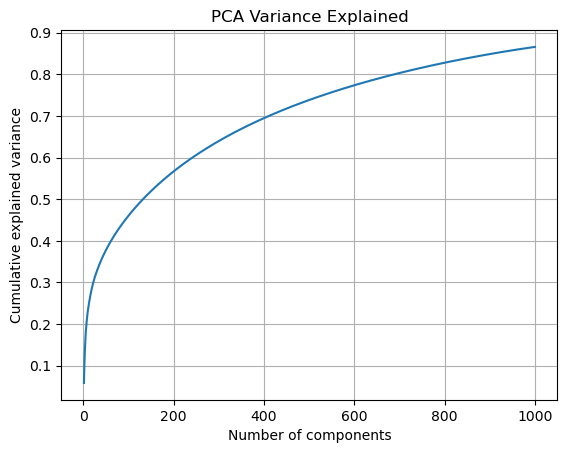

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)  # start big
X_pca = pca.fit_transform(df)

# Plot cumulative explained variance
import matplotlib.pyplot as plt
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Variance Explained")
plt.grid(True)
plt.show()


In [6]:
from sklearn.decomposition import PCA

# 2-component PCA for visualization
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(df)

print(f"Explained variance ratio (2D): {pca2.explained_variance_ratio_}")
print(f"Cumulative variance: {pca2.explained_variance_ratio_.sum():.2%}")


Explained variance ratio (2D): [0.05853086 0.04535005]
Cumulative variance: 10.39%


In [7]:
# Check variance per gene
gene_variances = df.var()

# How many genes have almost no variance?
low_variance_genes = (gene_variances < 1e-5).sum()
print(f"Number of near-zero variance genes: {low_variance_genes} / {df.shape[1]}")


Number of near-zero variance genes: 0 / 26148


In [8]:
print("Top 5 most variable genes:")
print(gene_variances.sort_values(ascending=False).head())


Top 5 most variable genes:
JC037706                  61.745630
DQ584545                  54.047892
DQ572382                  38.626593
SNORD81                   35.756868
septin 9/TNRC6C fusion    33.770684
dtype: float64


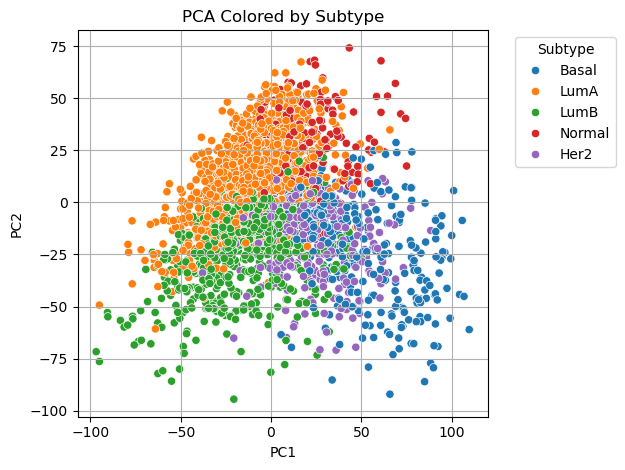

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Set 'title' as index in clinical_df
clinical_df_indexed = clinical_df.set_index("title")

# Step 2: Create PCA DataFrame using expression_df's index (which should match title)
pca_df = pd.DataFrame(X_pca2, columns=["PC1", "PC2"], index=expression_df.index)

# Step 3: Join PCA results with clinical metadata
pca_df = pca_df.join(clinical_df_indexed)

# Step 4: Plot PCA colored by subtype (adjust column name if needed)
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="characteristics_ch1.20.pam50 subtype", palette="tab10")
plt.title("PCA Colored by Subtype")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

# Reduce to 50 components (or use n_components_90 as discussed)
pca = PCA(n_components=3)
X_pca_kmeans = pca.fit_transform(expression_df)


# Set number of clusters (e.g. 5, since we have 5 subtypes)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca_kmeans)


In [11]:
pca_df["Cluster"] = cluster_labels  # assumes pca_df indexed by sample_id/title


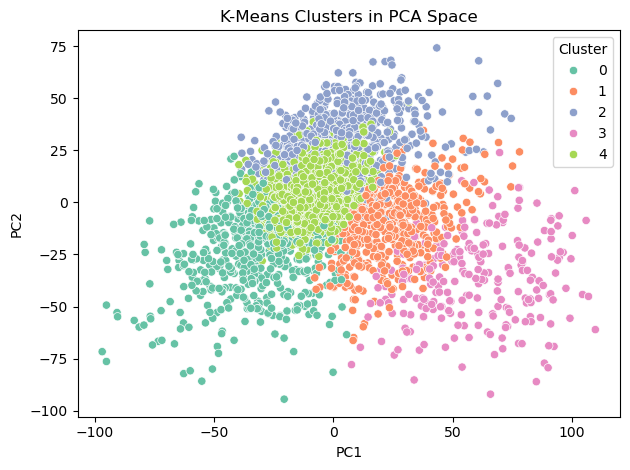

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set2")
plt.title("K-Means Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(pca_df["characteristics_ch1.20.pam50 subtype"], pca_df["Cluster"])
print(f"Adjusted Rand Index (ARI): {ari:.3f}")


Adjusted Rand Index (ARI): 0.180


In [ ]:
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler

# Normalize the data (important for PCA)
X_scaled = StandardScaler().fit_transform(df)

# Estimate robust mean and covariance
mcd = MinCovDet().fit(X_scaled)

# Center data using robust location estimate
X_centered = X_scaled - mcd.location_

# Apply standard PCA to robustly centered data
pca = PCA(n_components=2)  # Or more if needed
X_pca_robust = pca.fit_transform(X_centered)

# Optional: Plot
import matplotlib.pyplot as plt

plt.scatter(X_pca_robust[:, 0], X_pca_robust[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Robust PCA")
plt.show()


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.decomposition import PCA
# from sklearn.covariance import MinCovDet
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# # Step 1: Random subset of 500 samples
# np.random.seed(42)  # for reproducibility
# subset_df = df.sample(n=500, random_state=42)

# # Step 2: Normalize the data
# X_scaled = StandardScaler().fit_transform(subset_df)

# # Step 3: Estimate robust mean and covariance using MCD
# mcd = MinCovDet().fit(X_scaled)

# # Step 4: Center data using robust location estimate
# X_centered = X_scaled - mcd.location_

# # Step 5: Apply standard PCA to robustly centered data
# pca = PCA(n_components=2)
# X_pca_robust = pca.fit_transform(X_centered)

# # Step 6: Plot
# plt.scatter(X_pca_robust[:, 0], X_pca_robust[:, 1], alpha=0.7)
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.title("Robust PCA on Subset (n=500)")
# plt.grid(True)
# plt.show()
